In [1]:
"""
Jax implentation of the tempered bootstrap particle filter
"""

import jax.numpy as jnp
import jax.random as jr
from jax import Array, vmap, lax, jit
import jax

from resample.resamplers import RESAMPLERS
from feynmac_kac.utils import log_normalize, ess
from feynmac_kac.protocol import FeynmacKac, PFConfig, PFOutputs, CSMC

from jax.scipy.stats import multivariate_normal

from dynamax.linear_gaussian_ssm import lgssm_filter, lgssm_smoother
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

import matplotlib.pyplot as plt

from model.lgssm import LGSSMModel
from utils.datasets import load_dataset

from feynmac_kac.bootstrap import BootstrapParticleFilter


In [2]:
def find_temper_delta(log_w_norm, log_g_t, beta, ess_min):
    # Bisection on Δβ in [0, 1 - beta] so that ESS >= ess_min (as large as possible)
    left, right = 0.0, 1.0 - beta

    def ess_at(delta):
        lw_new = log_w_norm + delta * log_g_t
        lw_new -= jax.nn.logsumexp(lw_new)        # normalize
        return ess(jnp.exp(lw_new)), lw_new

    def bisect(_):

        def cond(carry):
            l, r = carry
            return (r - l) > 1e-3
            
        def body(carry):
            l, r = carry
            mid = 0.5 * (l + r)
            ess_mid, _ = ess_at(mid)
            
            # if ESS(mid) >= ess_min, we can take at least mid: move left up
            l = jnp.where(ess_mid >= (ess_min - 1e-3), mid, l)
            r = jnp.where(ess_mid >= (ess_min - 1e-3), r,  mid)
            # jax.debug.print("[bisect] l={:.6f} r={:.6f}", l, r)
            return (l, r)

        l, r = jax.lax.while_loop(cond, body, (left, right))
        mid = 0.5 * (l + r)
        return jnp.clip(mid, 1e-6, right)

    ess_r, _ = ess_at(right)
    delta = jax.lax.cond(
        ess_r >= ess_min,
        lambda _: right,
        lambda _: bisect(None),
        operand=None
    )
    
    return (delta, *ess_at(delta))


In [8]:

class TemperedBPF:
    """
    The Bootstrap PF takes the potential function as the emission likelihood,
    and the Markov transition kernel as the proposal distribution. Unlike a guided PF,
    the Bootstrap PF cannot use lookahead information from the observations when proposing particles.
    """

    def __init__(self, model: FeynmacKac, config: PFConfig):
        self.model = model
        self.cfg = config
        self.key = config.key
        self.resampler = RESAMPLERS[config.resample_scheme]

        self.vmapped_pt = vmap(lambda key, x, t: self.model.pt(key, x, t), in_axes=(0, 0, None))
        self.vmapped_log_g = vmap(self.model.log_g, in_axes=(None, 0, 0, None))
        self.vmapped_beta_pt =  vmap(lambda key, x, t, beta: self.model.beta_pt(key, x, t, beta), in_axes=(0, 0, None, None))

    def filter(self, key: jr.PRNGKey, T: int, obs: Array) -> PFOutputs:
        """
        """

        N = self.cfg.N
        ess_min = self.cfg.ess_threshold * N if self.cfg.ess_threshold is not None else jnp.inf    

        # t = 0 
        key0, key = jr.split(key)
        x_n0, log_wn0, norm_w_n0, logZ_0 = self.t0(key0, N, obs[0])

        def step(carry, obs_t):
            
            key, x_n_prev, log_wn_prev, norm_wn_prev, logZ_prev = carry
            key1, key2 = jr.split(key)
            t, y_t = obs_t

            jax.debug.print("[step] t={}", t)
            
            # tempering (does resampling and weight calculation)
            key_temper, x_nt, w_nt_norm, log_wnt, logZ_t, idx = self.temper(
                key1,           # RNG
                x_n_prev,       # previous particles
                log_wn_prev,    # previous log weights
                t,              # time index
                y_t,            # observation
                ess_min,        # ESS threshold
                N,              # number of particles
            )
            
            logZ = logZ_prev + logZ_t
            
            # track ESS and resampling index (dummy idx here, since temper handles resampling internally)
            ess_t = ess(w_nt_norm)
            
            return (key_temper, x_nt, log_wnt, w_nt_norm, logZ), (
                x_nt,
                w_nt_norm,
                idx,
                ess_t,
            )
        
        obs = (jnp.arange(1, T), obs[1:])
        carry0 = (key, x_n0, log_wn0, norm_w_n0, logZ_0)
        (key, _, _, w_nT_norm, logZ_hat), (particles, weights, ancestors, ess_hist) = lax.scan(step, carry0, obs)

        # prepend t=0
        particles = jnp.concatenate([x_n0[None, ...], particles], axis=0)               # (T+1, N, d)
        weights = jnp.concatenate([norm_w_n0[None, ...], weights], axis=0)              # (T+1, N)
        ess_hist = jnp.concatenate([ess_hist, jnp.array([ess(w_nT_norm)])], axis=0)     # (T+1,)

        self.key = key

        return PFOutputs(
            particles=particles,
            weights=weights,
            ancestors=ancestors,
            logZ_hat=logZ_hat,
            ess_history=ess_hist,
        )
    
    def t0(self, key: jr.PRNGKey, N, obs0: Array):
        x_n0 = self.model.p0(key, N)  # (N,d)
        log_wn0 = self.vmapped_log_g(0, x_n0, jnp.zeros_like(x_n0), obs0)  # (N,)
        norm_w_n0, logZ_0 = log_normalize(log_wn0)
        return x_n0, log_wn0, norm_w_n0, logZ_0
    
    def resample(self, key, N, norm_wn_prev, ess_min, x_n_prev, log_wn_prev):
        def do_resample(_):
            idx = self.resampler(key, norm_wn_prev)
            return x_n_prev[idx], jnp.zeros(N), idx
        
        def skip_resample(_):
            return x_n_prev, log_wn_prev, jnp.arange(N)
        
        ess_t = ess(norm_wn_prev)
        x_n_prev, log_wn_prev, idx = lax.cond(
            ess_t < ess_min,
            do_resample,
            skip_resample,
            operand=None
        )
        return x_n_prev, log_wn_prev, idx, ess_t
    
    def temper(self, key, x_nt, t, y_t, ess_min, N):
        """
        
        1. Sample x_nt_b as x_nt_b | x_nb_prev ~ N(A @ x_nb_prev, Q / b). If b=0 use x_n_prev.
        2. Calculate tempered log potentials (beta @ log_g_curr) using x_nt_b and y_t. 
        3. If ESS < ESS_min: resample.
        4. Repeat until b = 1
        """

        beta = 0.0
        log_wb = 
        logZ_t = 0.0

        # b = 0 steps
        log_g_curr = self.vmapped_log_g(t, x_nb_prev, x_n_prev, y_t)
        norm_wb, _ = log_normalize(log_wb)

        def cond(carry):
            beta, *_ = carry
            return (1.0 - beta) > 1e-6
            
        def step(carry):

            beta, key, x_nb_prev, norm_wb_prev, log_wb_prev, log_g_prev, logZ_t, _ = carry
            
            # potentially resample
            x_nb_res, log_wb, idx, ess_tb = self.resample(
                key, N, norm_wb_prev, ess_min, x_nb_prev, log_wb_prev
            )
    
            # compute Δβ that keeps ESS above threshold
            delta, _, _ = find_temper_delta(log_wb, log_g_prev, beta, ess_min)
            delta = jnp.minimum(delta, 1.0 - beta)
            # jax.debug.print("[beta, delta] beta={:.6f} delta={:.6f}", beta, delta)
            beta_next = beta + delta 
    
            # increment weighting
            log_wb = log_wb + (delta * log_g_prev)
            norm_wb, logZ_t_b = log_normalize(log_wb)
            logZ_t += logZ_t_b
    
            # sample β-tempered transition for next iteration
            keys = jr.split(key, N)
            x_nt_b = self.vmapped_beta_pt(keys, x_nb_res, t, beta_next)
            key, _ = jr.split(key)
            
            # compute new potentials for next step
            log_g_curr = self.vmapped_log_g(t, x_nt_b, x_nb_res, y_t)
    
            return beta_next, key, x_nt_b, norm_wb, log_wb, log_g_curr, logZ_t, idx
            
        
        beta, key, x_nt, norm_wb, log_wb, _, logZ_t, idx = jax.lax.while_loop(
            cond,
            step,
            (beta, key, x_nb_prev, norm_wb, log_wb, log_g_curr, logZ_t, jnp.arange(N))
        )
        return key, x_nt, norm_wb, log_wb, logZ_t, idx

        
        # def cond(carry):
        #     beta, *_ = carry
        #     return (1.0 - beta) > 1e-6

        # def step(carry):

        #     # extract required info
        #     beta, key, x_curr, log_w_norm, log_g_curr, logZ_t = carry
        #     key, subkey = jr.split(key)
            
        #     # find delta beta via numerical root finding to ess_min
        #     delta, ess_delta, lw_new = find_temper_delta(log_w_norm, log_g_curr, beta, ess_min)

        #     # increment log Z 
        #     logZ_inc = jax.nn.logsumexp(log_w_norm + delta * log_g_curr)
        #     logZ_t = logZ_t + logZ_inc

        #     # potentially resample
        #     w_new = jnp.exp(lw_new)
        #     ess_tb = ess(w_new)

        #     def do_resample(_):
        #         idx = self.resampler(subkey, w_new)
        #         return x_curr[idx], -jnp.log(N) * jnp.ones_like(lw_new), log_g_curr[idx], idx
        #     def skip_resample(_):
        #         return x_curr, lw_new, log_g_curr, jnp.arange(N)

        #     x_next, lw_next, log_g_next, _ = jax.lax.cond(
        #         ess_tb < ess_min,
        #         do_resample, 
        #         skip_resample,
        #         operand=None
        #     )
        #     # jax.debug.print("beta={:.6f} delta={:.6f} ESS={:.2f}", beta, delta, ess(jnp.exp(lw_new)))
        #     return (beta + delta, subkey, x_next, lw_next, log_g_next, logZ_t)

        # beta, key, x_nt, log_wnt, _, logZ_t = jax.lax.while_loop(
        #     cond,
        #     step,
        #     (beta, key, x_nt, log_w_norm, log_g_t, logZ_t)
        # )
        # return key, x_nt, log_wnt, logZ_t

            

## LGSSM Example

In [9]:
def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_smoother(params, y)
    print("Exact filter means shape: ", lgssm_posterior.smoothed_means.shape)
    return lgssm_posterior


def bpf(key, data, N: int):

    # parametrise model with the true parameters for now
    lgssm = LGSSMModel(data.params)
    
    # construct bootstrap particle filter
    bpf = BootstrapParticleFilter(
        model=lgssm,
        config=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.5,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key,
        T=data.train_data[0].shape[1],
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs

def tempered_bpf(key, data, N: int):

    # parametrise model with the true parameters for now
    lgssm = LGSSMModel(data.params)
    
    # construct bootstrap particle filter
    bpf = TemperedBPF(
        model=lgssm,
        config=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.2,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key,
        T=data.train_data[0].shape[1],
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs



In [10]:
data = load_dataset('linear_medium', seed=0)
data = data.standardized_data
lgssm_posterior = exact_filter(data)
x, y = data.train_states[0], data.train_data[0][0]

Exact filter means shape:  (300, 20)


In [11]:
outs = tempered_bpf(jr.PRNGKey(10), data, 5000)
outs.particles.shape, outs.weights.shape

[step] t=1
[step] t=2
[step] t=3
[step] t=4
[step] t=5
[step] t=6
[step] t=7
[step] t=8
[step] t=9
[step] t=10
[step] t=11
[step] t=12
[step] t=13
[step] t=14
[step] t=15
[step] t=16
[step] t=17
[step] t=18
[step] t=19
[step] t=20
[step] t=21
[step] t=22
[step] t=23
[step] t=24
[step] t=25
[step] t=26
[step] t=27
[step] t=28
[step] t=29
[step] t=30
[step] t=31
[step] t=32
[step] t=33
[step] t=34
[step] t=35
[step] t=36
[step] t=37
[step] t=38
[step] t=39
[step] t=40
[step] t=41
[step] t=42
[step] t=43
[step] t=44
[step] t=45
[step] t=46
[step] t=47
[step] t=48
[step] t=49
[step] t=50
[step] t=51
[step] t=52
[step] t=53
[step] t=54
[step] t=55
[step] t=56
[step] t=57
[step] t=58
[step] t=59
[step] t=60
[step] t=61
[step] t=62
[step] t=63
[step] t=64
[step] t=65
[step] t=66
[step] t=67
[step] t=68
[step] t=69
[step] t=70
[step] t=71
[step] t=72
[step] t=73
[step] t=74
[step] t=75
[step] t=76
[step] t=77
[step] t=78
[step] t=79
[step] t=80
[step] t=81
[step] t=82
[step] t=83
[step] t=84
[

((300, 5000, 20), (300, 5000))

Tempered BPF weighted x_t shape:  (300, 20)
MSE from BPF to exact filter means:  0.05185285


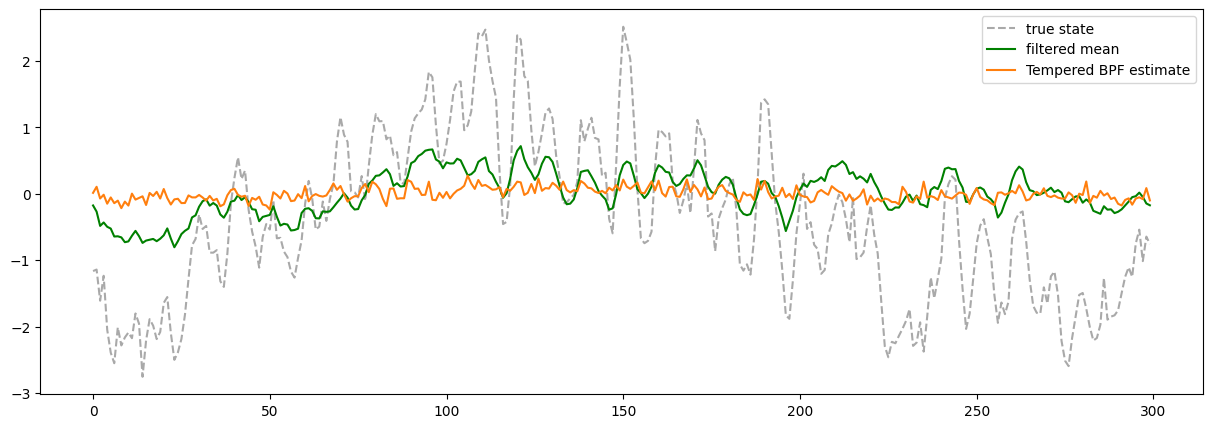

In [12]:
# calculate weighted estimates of state means
x_hat = jnp.sum(outs.weights[:, :, None] * outs.particles, axis=1)
print("Tempered BPF weighted x_t shape: ", x_hat.shape)

# calculate MSE against true filter means
mse = jnp.mean((x_hat - lgssm_posterior.filtered_means)**2)
print("MSE from BPF to exact filter means: ", mse)

# plot results
observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
fig, ax = plt.subplots(figsize=(15, 5))
# ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
# ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
ax.plot(x_hat[:, 3], color="tab:orange", label="Tempered BPF estimate")
plt.legend()
plt.show()

N: 50000                                                                                               
BPF particles shape:  (300, 50000, 20)
BPF weights shape:  (300, 50000)
BPF logZ_hat:  -7701.9995
BPF particles shape:  (300, 50000, 20)
BPF weights shape:  (300, 50000)
BPF logZ_hat:  -7801.4067
Tempered BPF weighted x_t shape:  (300, 20)
MSE from BPF to exact filter means:  0.07693892


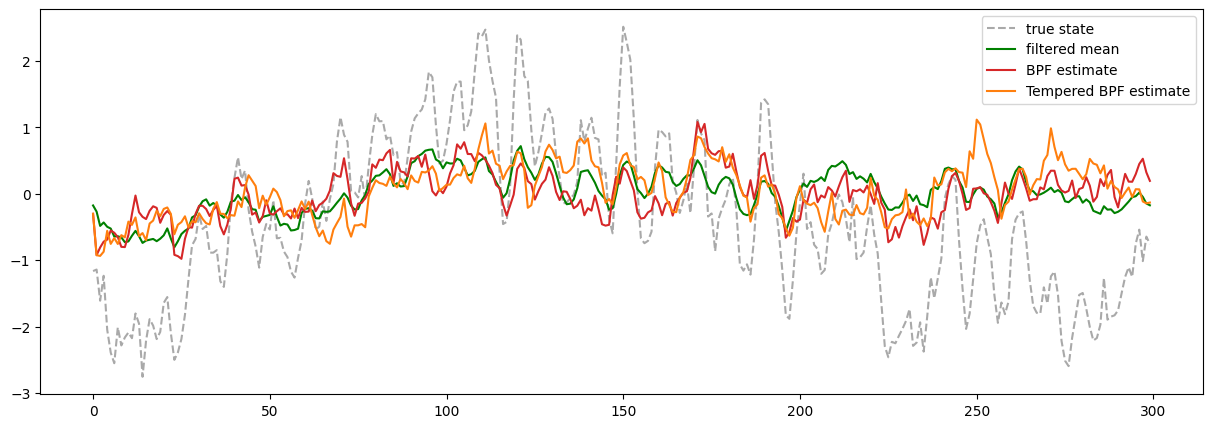

In [12]:
for N in [50000]:
    print(f"N: {N:<-100}")
    bpf_outs = bpf(jr.PRNGKey(N), data, N)
    tmp_outs = tempered_bpf(jr.PRNGKey(N), data, N)
    
    # calculate weighted estimates of state means
    bpf_x_hat = jnp.sum(bpf_outs.weights[:, :, None] * bpf_outs.particles, axis=1)
    tmp_x_hat = jnp.sum(tmp_outs.weights[:, :, None] * tmp_outs.particles, axis=1)
    print("Tempered BPF weighted x_t shape: ", tmp_x_hat.shape)
    
    # calculate MSE against true filter means
    mse = jnp.mean((tmp_x_hat - lgssm_posterior.filtered_means)**2)
    print("MSE from BPF to exact filter means: ", mse)
    
    # plot results
    observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
    fig, ax = plt.subplots(figsize=(15, 5))
    # ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
    ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
    # ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
    ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
    ax.plot(bpf_x_hat[:, 3], color="tab:red", label="BPF estimate")
    ax.plot(tmp_x_hat[:, 3], color="tab:orange", label="Tempered BPF estimate")
    plt.legend()
    plt.show()
    print("\n\n")